<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - Unveiling Chronic Disease in Singaporean Lifestyle

> Authors: Chung Yau, Gilbert, Han Kiong, Zheng Gang
---

**Problem Statement:**  
In Singapore, the increasing prevalence of chronic diseases presents a pressing public health concern, underscoring the need for proactive intervention strategies. 

How can we identify individuals at high risk for chronic diseases based on their behavioral habits? By doing so, we can enable early detection and provide recommendations, fostering a proactive approach to preventing various chronic diseases.

  
**Target Audience:**  
Product team in Synapxe, in preparation for Healthier SG 2025 roadmap workshop. 

These are the notebooks for this project:  
 1. `01_Data_Collection_Food.ipynb`  
 2. `02_Data_Preprocessing.ipynb`   
 3. `03_FeatureEngineering_and_EDA.ipynb`
 4. `04_Data_Modelling.ipynb` 
 5. `05_Hyperparameter_Model Fitting_Evaluation.ipynb`
 6. `05a_Model_Pickling.ipynb`
 7. `06_Implementation_FoodRecommender.ipynb` 

 ---

# This Notebook: 04 Data Modelling
- We will evaluate the various models in searching for the baseline model. 


To select the suitable baseline models, we first consider the interpretability and performance of the models as seen in the graph. Interpretability refers to the ease with which a model's predictions can be understood and explained while performance relates to whether the model can effectively captures patterns in the data and generalizes well to new instances.

<div style="text-align:center;">
    <img src="../assets/interpretability-vs-performance-trade-off.png" style="height: 500px;">
</div>

The table below compares the pros and cons of the different classification models:

| Classification Method           | Pros                                     | Cons                                                       | Usage Suggestions                                                                                                                  |
|--------------------------------|------------------------------------------|------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression             | - Interpretable coefficients             | - Assumes linear relationship                             | Use for straightforward interpretation of how each feature influences the risk of chronic diseases. Suitable for cases where linear relationships between features and outcome are plausible. |
| Decision Trees                  | - Easy to interpret and visualize       | - Prone to overfitting                                    | Use for initial exploration of feature importance and identification of relevant predictors. Prune the tree to prevent overfitting. Suitable for both numerical and categorical data. |
| Random Forest                   | - Reduces overfitting                   | - Less interpretable than Decision Trees                  | Use for improved generalization by combining multiple decision trees. Utilize feature importance measures to understand which lifestyle factors contribute most to the risk of chronic diseases. Suitable for large datasets. |
| Extra Trees                     | - Reduces variance further              | - Sacrifices interpretability for improved performance   | Use for faster training and potentially better performance compared to Random Forest. Particularly useful when computational resources are limited, and interpretability is not the primary concern. |
| Support Vector Machines (SVM)   | - Effective in high-dimensional spaces | - Complexity in choosing the appropriate kernel          | Use for finding optimal hyperplanes to separate high-risk and low-risk individuals. Requires careful selection of hyperparameters and choice of kernel function. Suitable for cases with complex, non-linear relationships. |
| k-Nearest Neighbors (k-NN)     | - Simple and intuitive                  | - Sensitive to irrelevant features                        | Use for identifying high-risk individuals based on similarity to other high-risk cases in the dataset. Normalize features and tune the number of neighbors to improve performance. Suitable for small to medium-sized datasets. |
| Naive Bayes                     | - Computationally efficient            | - Assumes strong independence between features            | Use for quick classification of high-risk individuals based on conditional probabilities. Suitable for cases with categorical features and where independence assumptions are not severely violated. |
| Gradient Boosting Machines (GBM)| - Combines weak learners to improve accuracy | - Can be computationally expensive and prone to overfitting | Use for building a strong predictive model by sequentially correcting errors of weak models. Regularize hyperparameters to prevent overfitting. Suitable for datasets with complex relationships and high predictive accuracy requirements. |
| AdaBoost                        | - Sequentially combines weak learners   | - Sensitive to noisy data                                 | Use for iteratively adjusting weights to focus on previously misclassified cases. Prune weak learners to improve generalization. Suitable for ensemble learning when there's a large imbalance between high-risk and low-risk individuals. |
| XGBoost                         | - High performance and scalability     | - Less interpretable than simpler models                  | Use for maximizing predictive accuracy and handling large datasets. Tune hyperparameters to balance bias and variance. Suitable for situations where interpretability is less critical compared to predictive power. |

After considering the pros and cons in terms of interpretability and performance, we have narrowed to 5 baseline models with a good balance of interpretability and performance. 

| Classifier                   | Interpretability | Performance | Recommendations                                                                                                                                                                  |
|------------------------------|------------------|-------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Logistic Regression          | High             | Moderate    | Suitable for linearly separable data, easy to interpret coefficients, works well with small to medium-sized datasets.                                                  |
| Random Forest                | Moderate         | High        | Combines multiple decision trees to reduce overfitting, robust to noise and outliers, suitable for large datasets with high dimensionality.                            |
| Support Vector Machines (SVM)| Low              | High        | Effective in high-dimensional spaces, versatile due to different kernel functions, can be memory intensive, suitable for small to medium-sized datasets.            |
| Gradient Boosting Machines (GBM)| Low           | High        | Ensemble method that combines weak learners to improve accuracy, less interpretable due to complexity, suitable for various types of data.                            |
| XGBoost                      | Low              | High        | Optimized implementation of gradient boosting, often outperforms other algorithms, less interpretable but highly accurate, suitable for large datasets.               |


---
### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

---
### Step 1: Obtaining cleaned dataset

This section involves the following: 
1. importing the dataset after exploratory data analysis (EDA) is performed
2. inspection of the dataframe, checking of null values
3. dropping of the '_RACE' column since the dataset has been filtered to include only asian during EDA
4. checking for the 'CD' class distribution (1: chronic and 0: not chronic)

##### 1.1 Importing the dataset after EDA

In [2]:
data_set = '../data/03_asian_data.csv'

df = pd.read_csv(data_set)

##### 1.2 Quick view of dataframe

In [3]:
# view the first 10 rows of the dataframe
df.head(10)

,heart_attack,stroke,asthma,skin_cancer,other_cancer,cpd_bronchitis,depression,kidney_disease,diabetes,sex,martial,employment_status,blind,diff_walking,occasion_drink_30days,high_bp,heart_disease,arthritis,race,age,height,education,smoker_status,one_alc_per_day,binge_drink,ave_drink_week,fruit,vegetable,exercise_cat,high_cholesterol,weight,BMI,CD
0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,5,0,0,0,4,7.0,173.00000,2,0,1,0,2.330000e+02,0,0,2,1,6804.000000,22.733803,0
1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,4,3.0,157.00000,1,0,0,0,5.397605e-79,0,0,0,0,5897.000000,23.923891,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,4,10.0,173.00000,2,0,0,0,5.397605e-79,0,1,1,1,6350.000000,21.216880,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,4,8.0,169.36927,1,0,0,0,5.397605e-79,0,0,1,1,8048.087779,28.055853,1
4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,5,0,0,0,4,9.0,180.00000,2,1,1,0,1.170000e+02,1,1,2,0,7484.000000,23.098765,0
5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,4,1.0,175.00000,1,0,1,0,4.700000e+01,1,1,1,0,9072.000000,29.622857,0
6,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,4,5.0,165.00000,2,1,0,0,5.397605e-79,0,1,0,1,5897.000000,21.660239,1
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.0,152.00000,1,0,0,0,5.397605e-79,0,0,1,0,4536.000000,19.632964,0
8,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,4,2.0,168.00000,2,0,0,0,5.397605e-79,0,1,1,0,6577.000000,23.302863,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,1.0,165.00000,0,0,0,0,5.397605e-79,1,1,2,0,4445.000000,16.326905,0


In [4]:
# check the rows and columns in the dataframe
df.shape

(16104, 33)

In [5]:
# view the columns in the dataframe
df.columns

Index(['heart_attack', 'stroke', 'asthma', 'skin_cancer', 'other_cancer',
       'cpd_bronchitis', 'depression', 'kidney_disease', 'diabetes', 'sex',
       'martial', 'employment_status', 'blind', 'diff_walking',
       'occasion_drink_30days', 'high_bp', 'heart_disease', 'arthritis',
       'race', 'age', 'height', 'education', 'smoker_status',
       'one_alc_per_day', 'binge_drink', 'ave_drink_week', 'fruit',
       'vegetable', 'exercise_cat', 'high_cholesterol', 'weight', 'BMI', 'CD'],
      dtype='object')

In [6]:
# check for null/nan values
df.isnull().sum()

heart_attack             0
stroke                   0
asthma                   0
skin_cancer              0
other_cancer             0
cpd_bronchitis           0
depression               0
kidney_disease           0
diabetes                 0
sex                      0
martial                  0
employment_status        0
blind                    0
diff_walking             0
occasion_drink_30days    0
high_bp                  0
heart_disease            0
arthritis                0
race                     0
age                      0
height                   0
education                0
smoker_status            0
one_alc_per_day          0
binge_drink              0
ave_drink_week           0
fruit                    0
vegetable                0
exercise_cat             0
high_cholesterol         0
weight                   0
BMI                      0
CD                       0
dtype: int64

##### 1.3 Dropping of '_RACE' column

In [7]:
# check for '_RACE'=4 (Asian)
df['race'].unique()

array([4], dtype=int64)

With this check, there is only 1 unique values in the '_RACE' column and confirms that the dataset has been filtered for asian during the EDA. 

In [8]:
# drop '_RACE' column
df.drop(columns=['race'], inplace=True)

In [9]:
# check columns to ensure '_RACE' has been dropped
df.columns

Index(['heart_attack', 'stroke', 'asthma', 'skin_cancer', 'other_cancer',
       'cpd_bronchitis', 'depression', 'kidney_disease', 'diabetes', 'sex',
       'martial', 'employment_status', 'blind', 'diff_walking',
       'occasion_drink_30days', 'high_bp', 'heart_disease', 'arthritis', 'age',
       'height', 'education', 'smoker_status', 'one_alc_per_day',
       'binge_drink', 'ave_drink_week', 'fruit', 'vegetable', 'exercise_cat',
       'high_cholesterol', 'weight', 'BMI', 'CD'],
      dtype='object')

##### 1.4 Checking the class distribution in 'CD' column

In [10]:
# finding the unique values in 'CD' column
print(df['CD'].unique())

# finding the count and percentage of 1: chronic and 0: not chronic in the 'CD' column
print(df['CD'].value_counts())
print(df['CD'].value_counts(normalize = True)*100)

[0 1]
CD
0    10631
1     5473
Name: count, dtype: int64
CD
0    66.014655
1    33.985345
Name: proportion, dtype: float64


- As seen, the classes are unbalanced with 66.0% for 0 (not chronic) and 34.0% for 1 (chronic).
- There are 2 options to balance the classes, namely undersampling or oversampling. 
- We will try both options and compare the scores for the baseline models based on undersampling and oversampling.  

### Step 2: Transforming and Modelling

Before we create the models, we will be applying a few tools or techniques to do data preprocessing, feature engineering and dimensionality reduction as follows: 

1. Class Balancing: 
- `RandomUnderSampler` aims to balance the class distribution by randomly selecting a subset of instances from the majority class (or classes) such that the resulting dataset is more balanced. The idea is to reduce the number of instances in the majority class to match the number of instances in the minority class, thus creating a more balanced dataset for training the model.
- `ADASYN` algorithm aims to balance the class distribution by generating synthetic samples for the minority class (class 1 in your case). However, it doesn't guarantee an exact balance between the classes after resampling. The imbalance might still exist due to the nature of the algorithm and the distribution of instances in the feature space.
2. PolynomialFeatures: `PolynomialFeatures` is a preprocessing module that generates polynomial features from the original features useful for capturing non-linear relationships between features. For example, if you have a feature x, PolynomialFeatures can create new features like x^2, x^3, etc.
3. StandardScaler: `StandardScaler` is a preprocessing technique used to standardize features by removing the mean and scaling to unit variance. We apply to numerical features to ensure that they have a mean of 0 and a standard deviation of 1. This is important for many machine learning algorithms that assume data is centered and has a consistent scale.
4. Principal Component Analysis: `PCA` is a dimensionality reduction technique used to reduce the number of features in a dataset while preserving most of the information. It does this by transforming the original features into a new set of orthogonal (uncorrelated) features called principal components. These principal components are ordered by the amount of variance they explain in the data, allowing you to select a subset of components to represent the data more efficiently.

##### 2.1 Determine the n_component for PCA

As we will be generating polynomial features from the original features, we are interested in reducing the dimensions as a result of these additional polynomial features. 

In order to determine the n_component for PCA, we will perform the following steps:
1. Balance our data by undersampling (with RandomUnderSampler) or oversampling (with ADASYN) (undersamping is chosen eventually)
2. Polynomial feature the numeric continous columns 
2. Standardscale our data before applying PCA (to prevent features with high scale from dominating the calculation)
2. Instantiate, fit and transform PCA on the scaled training data
3. Transform PCA on the test data
4. Pull the explained variance attribute (to explain the amount of variance by each of the newly created principal components)

In [11]:
# split our data into training and testing sets.
# set a custom test size of 20% for model evaluation.
columns_to_check = [
    'cpd_bronchitis',  
    'depression',    
    'arthritis',      
    'heart_attack',   
    'stroke',        
    'asthma',       
    'diabetes',      
    'kidney_disease', 
    'heart_disease',  
    'CD',        
    'height',        
    'weight'        
]

X_pca = df.drop(columns=['CD'])
y_pca = df['CD']

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca)

# Apply ADASYN to balance the classes
rus = RandomUnderSampler(random_state = 42)
X_train_resampled_p, y_train_resampled_p = rus.fit_resample(X_train_pca, y_train_pca)

# Define columns you want to apply polynomial features to
poly_cols = [
    'occasion_drink_30days', 
    'BMI',                
    'education',          
    'smoker_status',       
    'exercise_cat',    
    'ave_drink_week',     
    'age'              
]

# Create a ColumnTransformer to apply PolynomialFeatures to selected columns
poly_transformer = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(), poly_cols)
    ],
    remainder='passthrough'  # Pass through columns not specified for polynomial features
)

# Fit and transform the resampled data with polynomial features
X_train_poly_resampled = poly_transformer.fit_transform(X_train_resampled_p)
X_test_poly = poly_transformer.transform(X_test_pca)

# Standard scale the resampled data
scaler = StandardScaler()
X_train_sc_resampled = scaler.fit_transform(X_train_poly_resampled)
X_test_sc = scaler.transform(X_test_poly)

In [12]:
# Instantiate PCA.
pca = PCA(random_state = 42)

# Fit and Transform PCA on the scaled training data from X_train_sc to Z_train (PC) features.
Z_train = pca.fit_transform(X_train_sc_resampled)

# Check out the results in a dataframe.
pd.DataFrame(Z_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,-1.601840,-0.640847,-0.983666,0.026669,0.774594,-1.874834,-0.378492,-1.894257,0.019284,0.283224,-0.151174,-0.254283,-0.106419,0.355358,0.673602,0.830963,0.193680,0.222186,0.116804,0.435427,-0.433507,-0.407057,0.124259,-0.023591,0.390032,-1.717121,0.243338,-0.168488,0.186589,-0.289199,0.368435,0.165026,-0.238586,-0.063236,0.012520,0.319738,-0.073011,0.093482,-0.054032,0.020647,0.232622,0.004366,-0.030311,0.005392,-0.028131,0.259480,-0.143949,-0.002596,-0.038614,-0.004471,0.054296,-0.025513,0.008078,-0.012486,-0.076529,0.003102,0.025376,0.051977,0.003774,2.088207e-14
1,1.231852,-2.346142,-0.996811,2.698839,0.405108,0.323427,-0.908849,-0.785838,0.014770,0.428181,-0.021008,0.215787,-0.019156,-0.287076,-0.056573,0.590981,-0.452951,0.372590,-0.148825,0.257114,-0.093216,0.448759,-0.358268,-0.198548,0.505185,1.422810,-0.149852,-0.427276,-0.339285,-0.067443,0.426936,-0.231448,0.080221,0.037616,0.067108,-0.187752,-0.173375,0.163607,-0.409616,-0.020111,-0.192068,0.094978,0.006406,0.040471,0.083877,-0.090021,0.014841,-0.050653,-0.054207,-0.066739,-0.015158,0.040304,-0.050093,0.007385,0.003378,0.008272,-0.008864,0.015461,-0.006014,6.152584e-18
2,-1.377791,-1.174135,-1.960025,1.842926,-0.784641,-0.450303,0.531102,0.602361,0.563252,0.194218,-1.127771,-0.283244,0.525885,0.398710,0.196922,0.041428,0.220244,0.014736,-0.015110,0.072242,0.231779,-0.004365,0.461692,0.245807,1.072430,0.621528,-1.267783,0.807717,0.357322,0.353899,-0.155698,-0.270258,0.071122,0.002615,0.122814,0.102884,-0.045922,0.075392,-0.107396,0.074456,-0.009381,0.000629,-0.138601,-0.048610,-0.071922,-0.141192,-0.021444,0.175808,0.035646,0.001228,0.043521,-0.003171,0.001530,0.027751,0.024552,-0.088369,0.023391,0.009392,0.010279,4.694717e-18
3,-2.123105,2.529432,1.755920,-2.939549,0.265498,-0.689957,0.907990,0.016157,-0.330340,-0.812595,1.154606,0.170770,-0.747311,0.497810,-0.695236,-0.373344,0.062177,0.456499,-0.597408,-0.295702,0.331352,1.085464,-0.158075,0.048308,-1.235012,-0.384014,-2.001023,-1.953641,-0.978375,-0.285097,-0.171234,-0.596076,0.469973,-0.023008,0.404738,-0.600903,0.115645,0.130373,-0.214514,0.107131,0.154791,0.225228,-0.193171,0.108287,-0.257320,-0.192196,0.128299,-0.086849,0.101524,-0.009368,-0.020154,0.017666,0.056740,0.095671,0.066224,-0.012885,0.069428,0.017746,-0.011683,1.105160e-17
4,-1.761358,-2.251735,0.878684,1.131911,-2.250111,1.961381,0.142625,0.443099,0.465713,0.240151,-0.402122,-0.209633,0.672818,0.616404,-0.213678,-0.430959,0.423286,-0.131839,-0.260334,-0.466644,-0.002420,0.309171,0.174355,-0.347072,-0.475326,1.145155,-0.563235,0.403334,0.039631,0.509803,-0.554643,-0.384968,0.314884,0.091894,0.058430,-0.265742,0.254026,0.063820,-0.384125,0.219231,0.227178,-0.354058,0.326576,0.013438,-0.028200,-0.036865,0.031667,-0.133025,-0.005694,-0.064845,-0.020966,0.021561,0.014850,-0.040136,-0.075612,0.052611,-0.032804,0.013523,-0.001397,1.733881e-17


In [13]:
# Transform the test data
Z_test = pca.transform(X_test_sc)

# Check out the results in a dataframe.
pd.DataFrame(Z_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,-0.828254,0.119166,0.135020,3.671401,-1.020140,-1.229569,-0.465638,-0.521695,0.601154,0.176956,-0.309730,0.167770,0.033939,-0.433906,-0.122126,0.656998,-0.132899,0.510841,-0.082842,0.324439,-0.086460,0.445156,-0.453181,0.070990,-0.148505,0.626066,-0.982034,0.712641,-0.010345,0.154753,0.032808,0.807478,-0.971187,-0.011545,-0.131402,-0.198993,0.612741,0.061333,-0.333821,0.169366,-0.082504,0.343993,-0.236122,0.226492,0.022399,-0.212631,0.011712,0.134088,-0.031998,-0.017881,-0.013068,-0.059459,0.073184,0.124520,-0.019338,0.044046,0.082331,-0.029107,-0.008535,2.593443e-18
1,-0.848268,2.326184,5.530766,2.633174,-0.285820,-4.469285,0.478753,0.695374,0.631102,-1.128967,0.924448,-0.418833,-0.186514,-0.751774,-1.689482,0.311650,0.528028,0.534501,-0.031267,0.418879,0.240262,0.273396,-0.261327,0.802925,-0.488801,-0.459396,-0.056920,0.314993,-0.254198,0.637259,0.605876,-2.075718,0.640686,-0.019890,-1.701113,0.871178,1.704187,-0.715255,0.433265,-0.275521,-0.920652,-0.404637,0.234945,0.184116,0.497862,0.269911,-0.118069,0.201996,-0.014644,0.045696,-0.034928,-0.085613,0.048076,0.172408,0.170384,0.277750,0.151340,-0.058419,-0.021100,8.375107e-18
2,-1.960326,1.272612,-2.402175,-1.403092,-3.448164,0.468886,0.814892,0.393272,-0.035223,0.209374,0.125957,0.373020,-0.421528,1.134400,-0.362347,-0.642886,-1.713634,-0.301525,-0.650167,-0.186636,-0.425797,-2.587938,1.291566,0.051774,-0.138538,-0.400764,-0.709612,-0.477415,1.282393,0.022755,0.518860,0.135723,0.204726,-0.114863,-0.314939,0.067155,0.014881,-0.337146,0.429561,-0.161309,-0.313517,0.033219,0.188475,0.191447,0.134293,-0.134077,0.112312,-0.299560,0.081411,0.012269,0.004247,0.049621,-0.060027,-0.025852,-0.104491,-0.097263,0.042904,-0.033106,0.003704,2.225037e-18
3,-1.721622,-1.771054,0.601862,1.024124,-2.045282,2.014134,-0.571373,-0.254063,-0.137017,-0.139633,0.884626,0.331600,0.295163,0.791238,-0.141246,-1.322553,0.544381,-0.378826,-0.236459,-0.646737,0.309525,0.322643,0.402555,0.052024,-0.588946,-0.017743,0.065785,0.390461,-1.852833,0.598112,0.192919,-0.098404,-1.012435,-0.044070,-0.068865,-0.347044,0.110554,0.105284,-0.312198,0.256797,0.268424,-0.297244,0.332091,-0.006504,0.030045,-0.003095,0.000611,-0.063937,0.038348,-0.062740,-0.016695,0.044203,0.013206,-0.042630,-0.096724,0.037589,-0.034523,-0.007910,-0.007255,7.004372e-18
4,4.863347,3.744723,5.950885,4.325532,-4.330916,-0.298262,0.723980,0.814940,0.459177,-0.638528,-2.451201,0.498072,0.891528,-0.095250,1.195335,0.106233,-0.290831,-0.279587,-0.154653,-0.226517,0.342977,1.229269,0.656798,-1.831250,1.477580,-0.585054,0.312511,-0.201685,-0.220040,-2.000678,-0.629451,1.602714,0.490555,0.013600,-0.999357,1.538656,-0.965553,0.593470,-0.775236,0.393924,-0.050962,-0.469339,0.413895,-0.151793,0.242871,-0.192525,0.142467,-0.097485,0.212941,0.220781,-0.029249,-0.378663,0.225277,0.074959,-0.018888,0.186607,0.084210,-0.090319,0.066228,-3.556460e-18


In [14]:
# Pull the explained variance attribute using ready-to-use method from sklearn's PCA.
# We can directly use this to explain the amount of variance explained by each of our newly created principal components
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 40 components): {np.round(var_exp[:40],3)}') # examine only 1st 40 variances, rounded to 3 decimals

Explained variance (first 40 components): [0.197 0.104 0.091 0.071 0.058 0.048 0.032 0.027 0.023 0.022 0.02  0.018
 0.018 0.018 0.017 0.016 0.015 0.015 0.015 0.014 0.014 0.014 0.013 0.012
 0.012 0.011 0.011 0.01  0.01  0.007 0.006 0.005 0.005 0.004 0.004 0.003
 0.003 0.002 0.002 0.002]


**Inferences:**
- The 1st principal component alone, can explain 19.% of the entire variation in the data
- The 2nd principal component alone, can explain 10.% of the entire variation in the data
- The 3rd principal component alone, can explain 9.1% of the entire variation in the data
and so on.

In [15]:
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 40 components): {np.round(cum_var_exp[:40],3)}')

Cumulative explained variance (first 40 components): [0.197 0.301 0.393 0.463 0.521 0.569 0.601 0.628 0.651 0.673 0.693 0.712
 0.73  0.747 0.764 0.78  0.795 0.81  0.825 0.839 0.853 0.867 0.88  0.892
 0.904 0.915 0.926 0.936 0.946 0.953 0.958 0.964 0.969 0.973 0.977 0.98
 0.982 0.985 0.987 0.989]


**Inferences:**
- 1st 3 principal components can explain 39.3% of the variation in the data
- 1st 18 principal components can explain 81% of the variation in the data
- 1st 30 principal components can explain 95.3% of the variation in the data

Given that we want to explain at least 95% of the variability in my data with principal components, the smallest number of principal components that we would need to keep is 30. 

To create the classification models, we will do the following:
1. Define X and y
2. Create a train-test split of X and y
3. Create a pipeline for the RandomUnderSampler/ ADASYN, PolynomialFeatures, StandardScaler, PCA (with identified n_components) and the classifiers<br>
4. Call and fit the respective classification models
5. Generate scoring metrics (accuracy, precision, recall, F1 score) to see how well the baseline model is performing

##### 2.2 Transforming and Modelling using RandomUnderSampler dataframe

In [16]:
# Train-test split and RandomUnderSampling sampling
columns_to_check = [
    'cpd_bronchitis',  
    'depression',    
    'arthritis',      
    'heart_attack',   
    'stroke',        
    'asthma',       
    'diabetes',      
    'kidney_disease', 
    'heart_disease',  
    'CD',        
    'height',        
    'weight'        
]

X = df.drop(columns=columns_to_check)
y = df['CD']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform RandomUnderSampler for class imbalance
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Define columns you want to apply polynomial features to

poly_cols = [
    'occasion_drink_30days', 
    'BMI',                
    'education',          
    'smoker_status',       
    'exercise_cat',    
    'ave_drink_week',     
    'age'              
]

# Create a ColumnTransformer to apply PolynomialFeatures to selected columns
poly_transformer = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(), poly_cols)
    ],
    remainder='passthrough'  # Pass through columns not specified for polynomial features
)

# Define PCA with n_components=30
pca = PCA(n_components=30)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Create an empty list to store the results
cv_results_list = []
train_results_list = []
test_results_list = []

# Perform cross-validation, train, and test scoring for each classifier
for clf_name, clf in classifiers.items():
    # Create pipeline for each classifier
    pipeline = Pipeline([
        ('poly_transformer', poly_transformer),  # Apply polynomial features only to specified columns
        ('std_scaler', StandardScaler()),
        ('pca', pca),  # Apply PCA with n_components=30
        ('classifier', clf)
    ])

    # Cross-validation scores
    cv_scores = cross_validate(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring=['precision', 'recall', 'f1', 'accuracy'])
    cv_results_list.append({
        'Classifier': clf_name,
        'Precision': cv_scores['test_precision'].mean(),
        'Recall': cv_scores['test_recall'].mean(),
        'F1': cv_scores['test_f1'].mean(),
        'Accuracy': cv_scores['test_accuracy'].mean()
    })

    # Train scores
    pipeline.fit(X_train_resampled, y_train_resampled)
    train_preds = pipeline.predict(X_train_resampled)
    train_accuracy = accuracy_score(y_train_resampled, train_preds)
    train_precision = precision_score(y_train_resampled, train_preds)
    train_recall = recall_score(y_train_resampled, train_preds)
    train_f1 = f1_score(y_train_resampled, train_preds)
    train_results_list.append({
        'Classifier': clf_name,
        'Precision': train_precision,
        'Recall': train_recall,
        'F1': train_f1,
        'Accuracy': train_accuracy
    })

    # Test scores
    test_preds = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds)
    test_recall = recall_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)
    test_results_list.append({
        'Classifier': clf_name,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1': test_f1,
        'Accuracy': test_accuracy
    })

# Create DataFrames for cross-validation, train, and test results
cv_results_df = pd.DataFrame(cv_results_list)
train_results_df = pd.DataFrame(train_results_list)
test_results_df = pd.DataFrame(test_results_list)

Cross-validation scores (precision, recall, F1, accuracy) for the baseline models

In [17]:
# cross-validation scores for the 5 baseline models
cv_results_df

,Classifier,Precision,Recall,F1,Accuracy
0,Logistic Regression,0.721346,0.626320,0.670351,0.692211
1,Random Forest,0.660420,0.676110,0.668159,0.664229
2,Support Vector Classifier,0.707471,0.632027,0.667590,0.685358
3,Gradient Boosting Classifier,0.704099,0.648932,0.675311,0.688098
4,XGBoost,0.661198,0.649385,0.655201,0.658290


Train scores (precision, recall, F1, accuracy) for the baseline models

In [18]:
# train scores for the 5 baseline models
train_results_df

,Classifier,Precision,Recall,F1,Accuracy
0,Logistic Regression,0.726816,0.628369,0.674017,0.696094
1,Random Forest,0.999542,0.997031,0.998285,0.998287
2,Support Vector Classifier,0.747671,0.659890,0.701043,0.718593
3,Gradient Boosting Classifier,0.751747,0.688214,0.718579,0.730471
4,XGBoost,0.984586,0.948378,0.966143,0.966766


Test scores (precision, recall, F1, accuracy) for the baseline models

In [19]:
# test scores for the 5 baseline models
test_results_df

,Classifier,Precision,Recall,F1,Accuracy
0,Logistic Regression,0.581981,0.654795,0.616244,0.722757
1,Random Forest,0.482781,0.665753,0.559693,0.643899
2,Support Vector Classifier,0.566008,0.653881,0.606780,0.711891
3,Gradient Boosting Classifier,0.553788,0.667580,0.605383,0.704129
4,XGBoost,0.489377,0.631050,0.551256,0.650730


In [20]:
# Combine resampled features with labels into a single DataFrame
undersampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
undersampled_df['CD'] = y_train_resampled

# Export the resampled DataFrame to a CSV file
undersampled_df.to_csv('../data/undersampled_df.csv', index=False)

##### 2.3 Transforming and Modelling using ADASYN oversampled dataframe

In [21]:
# Train-test split and ADASYN sampling

columns_to_check2 = [
    'cpd_bronchitis', 
    'depression',    
    'arthritis',    
    'heart_attack',   
    'stroke',       
    'asthma',     
    'diabetes',      
    'kidney_disease', 
    'heart_disease', 
    'CD',           
    'height',         
    'weight'      
]

X2 = df.drop(columns=columns_to_check2)
y2 = df['CD']

# Split the data into train and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

# Perform ADASYN sampling for class imbalance
adasyn = ADASYN(random_state=42)
X2_train_resampled, y2_train_resampled = adasyn.fit_resample(X2_train, y2_train)

# Define columns you want to apply polynomial features to
poly_cols = [
    'occasion_drink_30days',
    'BMI',             
    'education',   
    'smoker_status',   
    'exercise_cat',      
    'ave_drink_week',    
    'age'              
]

# Create a ColumnTransformer to apply PolynomialFeatures to selected columns
poly_transformer = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(), poly_cols)
    ],
    remainder='passthrough'  # Pass through columns not specified for polynomial features
)

# Define PCA with n_components=30
pca = PCA(n_components=30)

# Define classifiers
classifiers2 = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Create an empty list to store the results
cv_results_list2 = []
train_results_list2 = []
test_results_list2 = []

# Perform cross-validation, train, and test scoring for each classifier
for clf_name, clf in classifiers2.items():
    # Create pipeline for each classifier
    pipeline2 = Pipeline([
        ('poly_transformer', poly_transformer),  # Apply polynomial features only to specified columns
        ('std_scaler', StandardScaler()),
        ('pca', pca),  # Apply PCA with n_components=18
        ('classifier', clf)
    ])

    # Cross-validation scores
    cv_scores2 = cross_validate(pipeline2, X2_train_resampled, y2_train_resampled, cv=5, scoring=['precision', 'recall', 'f1', 'accuracy'])
    cv_results_list2.append({
        'Classifier': clf_name,
        'Precision': cv_scores2['test_precision'].mean(),
        'Recall': cv_scores2['test_recall'].mean(),
        'F1': cv_scores2['test_f1'].mean(),
        'Accuracy': cv_scores2['test_accuracy'].mean()
    })

    # Train scores
    pipeline2.fit(X2_train_resampled, y2_train_resampled)
    train_preds2 = pipeline2.predict(X2_train_resampled)
    train_accuracy2 = accuracy_score(y2_train_resampled, train_preds2)
    train_precision2 = precision_score(y2_train_resampled, train_preds2)
    train_recall2 = recall_score(y2_train_resampled, train_preds2)
    train_f1_2 = f1_score(y2_train_resampled, train_preds2)
    train_results_list2.append({
        'Classifier': clf_name,
        'Precision': train_precision2,
        'Recall': train_recall2,
        'F1': train_f1_2,
        'Accuracy': train_accuracy2
    })

    # Test scores
    test_preds2 = pipeline2.predict(X2_test)
    test_accuracy2 = accuracy_score(y2_test, test_preds2)
    test_precision2 = precision_score(y2_test, test_preds2)
    test_recall2 = recall_score(y2_test, test_preds2)
    test_f1_2 = f1_score(y2_test, test_preds2)
    test_results_list2.append({
        'Classifier': clf_name,
        'Precision': test_precision2,
        'Recall': test_recall2,
        'F1': test_f1_2,
        'Accuracy': test_accuracy2
    })

# Create DataFrames for cross-validation, train, and test results
cv_results_df2 = pd.DataFrame(cv_results_list2)
train_results_df2 = pd.DataFrame(train_results_list2)
test_results_df2 = pd.DataFrame(test_results_list2)

Cross-validation scores (precision, recall, F1, accuracy) for the baseline models

In [22]:
# cross-validation scores for the 5 baseline models
cv_results_df2

,Classifier,Precision,Recall,F1,Accuracy
0,Logistic Regression,0.675770,0.590264,0.629615,0.652517
1,Random Forest,0.697813,0.732935,0.714713,0.706925
2,Support Vector Classifier,0.685092,0.612716,0.646501,0.664536
3,Gradient Boosting Classifier,0.672169,0.643238,0.657109,0.663716
4,XGBoost,0.684112,0.685577,0.684645,0.683650


Train scores (precision, recall, F1, accuracy) for the baseline models

In [23]:
# train scores for the 5 baseline models
train_results_df2

,Classifier,Precision,Recall,F1,Accuracy
0,Logistic Regression,0.687712,0.616464,0.650142,0.667351
1,Random Forest,0.997896,0.998480,0.998188,0.998183
2,Support Vector Classifier,0.726339,0.661366,0.692331,0.705282
3,Gradient Boosting Classifier,0.708338,0.688377,0.698215,0.701647
4,XGBoost,0.924147,0.908910,0.916465,0.916926


Test scores (precision, recall, F1, accuracy) for the baseline models

In [24]:
# test scores for the 5 baseline models
test_results_df2

,Classifier,Precision,Recall,F1,Accuracy
0,Logistic Regression,0.532567,0.634703,0.579167,0.686433
1,Random Forest,0.500372,0.614612,0.551639,0.660354
2,Support Vector Classifier,0.550623,0.645662,0.594367,0.700404
3,Gradient Boosting Classifier,0.518625,0.661187,0.581293,0.676188
4,XGBoost,0.503666,0.627397,0.558764,0.663148


In [25]:
# Combine resampled features with labels into a single DataFrame
oversampled_df = pd.DataFrame(X2_train_resampled, columns=X2.columns)
oversampled_df['CD'] = y2_train_resampled

# Export the resampled DataFrame to a CSV file
oversampled_df.to_csv('../data/oversampled_df.csv', index=False)

In [26]:
oversampled_df.head()

,skin_cancer,other_cancer,sex,martial,employment_status,blind,diff_walking,occasion_drink_30days,high_bp,age,education,smoker_status,one_alc_per_day,binge_drink,ave_drink_week,fruit,vegetable,exercise_cat,high_cholesterol,BMI,CD
0,0,1,1,1,1,0,1,0,1,10.0,2,0,0,0,0.000000e+00,1,1,2,0,21.694303,1
1,0,0,0,1,0,0,0,0,0,3.0,1,0,0,0,0.000000e+00,1,0,1,0,30.731303,0
2,0,0,1,0,1,0,0,4,0,1.0,1,0,0,0,0.000000e+00,0,0,1,0,22.038567,0
3,0,0,0,0,1,0,0,1,0,6.0,1,3,1,0,2.100000e+01,1,0,0,0,25.027384,0
4,0,0,1,1,1,0,0,0,0,3.0,2,0,0,0,5.397605e-79,1,1,0,0,27.399184,0


Some considerations about applying principal component analysis:
- While PCA (Principal Component Analysis) is often used for dimensionality reduction, it can sometimes lead to a loss of information, particularly if the original dimensions contain important features for classification. This loss of information can result in decreased accuracy, precision, recall, and F1 score, especially if the reduced dimensions do not capture enough variability in the data to effectively distinguish between classes. 
- Since we have managed to reduce the number of columns from the original 60 to 30, and managed to retain > 95% of the information. **We have decided to proceed with having n_components = 30 for our analysis.**

The main benefits of PCA that made the team come to this conclusion are: 
1. **Removes Correlated Features:** By converting correlated variables into a set of linearly uncorrelated variables (principal components), PCA helps in removing redundancy in the dataset. This can be particularly useful in models where multicollinearity may be a problem.

2. **Optimizes Performance:** Reducing the dimensionality of the data can lead to faster training times and can help in combating the curse of dimensionality, where the feature space becomes so large that the model starts to overfit. By focusing on the most informative aspects of the original data, PCA can lead to more generalized models.




### Step 3: Export Model Evaluation Result 
For offline reference and recording purpose

Undersampling using RandomUnderSampler

In [27]:
# Concatenate cross-validation, train, and test results DataFrames
merged_df = pd.concat([cv_results_df.set_index('Classifier'), 
                       train_results_df.set_index('Classifier'), 
                       test_results_df.set_index('Classifier')],
                      axis=1, keys=['cv', 'train', 'test'])

# Reset index to make 'Classifier' a column again
merged_df.reset_index(inplace=True)

# Rename columns
merged_df.columns = ['Classifier', 
                     'cv_precision', 'cv_recall', 'cv_f1', 'cv_accuracy',
                     'train_precision', 'train_recall', 'train_f1', 'train_accuracy',
                     'test_precision', 'test_recall', 'test_f1', 'test_accuracy']

merged_df


,Classifier,cv_precision,cv_recall,cv_f1,cv_accuracy,train_precision,train_recall,train_f1,train_accuracy,test_precision,test_recall,test_f1,test_accuracy
0,Logistic Regression,0.721346,0.626320,0.670351,0.692211,0.726816,0.628369,0.674017,0.696094,0.581981,0.654795,0.616244,0.722757
1,Random Forest,0.660420,0.676110,0.668159,0.664229,0.999542,0.997031,0.998285,0.998287,0.482781,0.665753,0.559693,0.643899
2,Support Vector Classifier,0.707471,0.632027,0.667590,0.685358,0.747671,0.659890,0.701043,0.718593,0.566008,0.653881,0.606780,0.711891
3,Gradient Boosting Classifier,0.704099,0.648932,0.675311,0.688098,0.751747,0.688214,0.718579,0.730471,0.553788,0.667580,0.605383,0.704129
4,XGBoost,0.661198,0.649385,0.655201,0.658290,0.984586,0.948378,0.966143,0.966766,0.489377,0.631050,0.551256,0.650730


In [28]:
#Export data to csv
merged_df.to_csv('../data/04_model_evaluation_result_undersampled.csv')

Oversampling using ADASYN

In [29]:
# Concatenate cross-validation, train, and test results DataFrames
merged_df1 = pd.concat([cv_results_df2.set_index('Classifier'), 
                        train_results_df2.set_index('Classifier'), 
                        test_results_df2.set_index('Classifier')],
                        axis=1, keys=['cv', 'train', 'test'])

# Reset index to make 'Classifier' a column again
merged_df1.reset_index(inplace=True)

# Rename columns
merged_df1.columns = ['Classifier', 
                     'cv_precision', 'cv_recall', 'cv_f1', 'cv_accuracy',
                     'train_precision', 'train_recall', 'train_f1', 'train_accuracy',
                     'test_precision', 'test_recall', 'test_f1', 'test_accuracy']

merged_df1

,Classifier,cv_precision,cv_recall,cv_f1,cv_accuracy,train_precision,train_recall,train_f1,train_accuracy,test_precision,test_recall,test_f1,test_accuracy
0,Logistic Regression,0.675770,0.590264,0.629615,0.652517,0.687712,0.616464,0.650142,0.667351,0.532567,0.634703,0.579167,0.686433
1,Random Forest,0.697813,0.732935,0.714713,0.706925,0.997896,0.998480,0.998188,0.998183,0.500372,0.614612,0.551639,0.660354
2,Support Vector Classifier,0.685092,0.612716,0.646501,0.664536,0.726339,0.661366,0.692331,0.705282,0.550623,0.645662,0.594367,0.700404
3,Gradient Boosting Classifier,0.672169,0.643238,0.657109,0.663716,0.708338,0.688377,0.698215,0.701647,0.518625,0.661187,0.581293,0.676188
4,XGBoost,0.684112,0.685577,0.684645,0.683650,0.924147,0.908910,0.916465,0.916926,0.503666,0.627397,0.558764,0.663148


In [30]:
#Export data to csv
merged_df1.to_csv('../data/04_model_evaluation_result_oversampled.csv')

### Step 4: Model Evaluation Outcome

Based on our problem statement, the task is to identify individuals at high risk for chronic diseases based on their lifestyle data. The significance of the evaluation metrics are as follows: 
- Accuracy: measures the proportion of correctly classified instances among all instances. In this context, accuracy indicates how well the model predicts both high-risk and not high-risk individuals. 
- Precision: measures the proportion of true high-risk individuals among all instances classified as high-risk. It focuses on minimizing false positives, i.e., instances wrongly classified as high-risk individuals. In this context, precision indicates the reliability of the model in correctly identifying high-risk individuals.
- Recall/ Sensitivity: measures the proportion of true high-risk individuals that are correctly identified by the classifier. It focuses on minimizing false negatives, i.e., high-risk individuals wrongly classified as not high-risk. In this context, recall indicates the ability of the model to capture all actual high-risk individuals.
- F1 Score: harmonic mean of precision and recall. It provides a balance between precision and recall, giving equal weight to both metrics. It summarizes the overall performance of the classifier, taking into account both precision and recall.

The team has chosen F1 score to be the main metric to focus on for the below reason: 

**Balanced Trade-Off**  
When both false positives and false negatives are equally undesirable:

- **False Positive (Wrongly identify an individual as high risk)**: Causes a false alarm, leading to unnecessary stress and resource allocation.
- **False Negative (Wrongly identify an individual as low risk)**: Fails to provide timely intervention, potentially leading to adverse health outcomes.

**Sensitivity to Class Imbalance**  
- Approximately 30% of Asians are medically diagnosed with a chronic disease in our dataset, indicating a significant prevalence that should be taken into account when designing and training predictive models to ensure they are sensitive to class imbalances.


#### 4.1 Comparison of Sampling Methods



These are the advantages and disadvantages for both methods:

Advantages: 
- RandomUnderSampler: Generally provides a balanced dataset by randomly removing samples from the majority class.
- ADASYN (Adaptive Synthetic Sampling): Generates synthetic samples for the minority class, focusing on areas where the class distribution is sparse.

Disadvantages: 
- RandomUnderSampler: It may discard potentially useful data, leading to loss of information.
- ADASYN (Adaptive Synthetic Sampling): May introduce noise into the dataset if not used carefully.

Based on the 4 metrics (accuracy, precision, recall and F1 score): 

| Classifier                     | Metric        | RandomUnderSampler | ADASYN    | Better Sampling Method |
|--------------------------------|---------------|--------------------|-----------|------------------------|
| Logistic Regression            | Precision     | Higher             | Lower     | RandomUnderSampler     |
|                                | Recall        | Higher             | Lower     | RandomUnderSampler     |
|                                | F1-score      | Higher             | Lower     | RandomUnderSampler     |
|                                | Accuracy      | Higher             | Lower     | RandomUnderSampler     |
| Random Forest                  | Precision     | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | Recall        | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | F1-score      | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | Accuracy      | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
| Support Vector Classifier      | Precision     | Higher             | Lower     | RandomUnderSampler     |
|                                | Recall        | Higher             | Lower     | RandomUnderSampler     |
|                                | F1-score      | Higher             | Lower     | RandomUnderSampler     |
|                                | Accuracy      | Higher             | Lower     | RandomUnderSampler     |
| Gradient Boosting Classifier   | Precision     | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | Recall        | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | F1-score      | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | Accuracy      | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
| XGBoost                        | Precision     | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | Recall        | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | F1-score      | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |
|                                | Accuracy      | Higher (Train), Lower (Test) | Lower (Train), Higher (Test) | Depends (Train/Test)    |

- RandomUnderSampler generally performs better than ADASYN across most classifiers, especially in terms of testing set metrics such as precision, recall, F1-score, and accuracy.
- However, the choice between sampling methods may also depend on the specific requirements of the problem and the importance of different evaluation metrics. For instance, if you prioritize generalization performance on unseen data (testing set), RandomUnderSampler might be preferred. However, if you prioritize maximizing recall or sensitivity, ADASYN might be more suitable as it tends to balance the class distribution more effectively.

**Overall, based on the comparison, we will take scores from the undersampling with RandomUnderSampler.**

#### 4.2 Model Evaluation based on Under Sampling

Comparison of the baseline models' cross-validation and train scores

In general, a smaller difference between the train score and cross-validation score is preferred, as it suggests better generalization performance and less overfitting. 

Accuracy:

| Model                        | Cross-Validation Score | Train Score | Difference |
|------------------------------|------------------------|-------------|------------|
| Logistic Regression          | 0.691868               | 0.696094    | 0.004226   |
| Random Forest                | 0.662859               | 0.998401    | 0.335542   |
| Support Vector Classifier    | 0.685358               | 0.718593    | 0.033235   |
| Gradient Boosting Classifier | 0.688669               | 0.730699    | 0.042030   |
| XGBoost                      | 0.650410               | 0.963796    | 0.313386   |

Precision:

| Model                        | Cross-Validation Score | Train Score | Difference |
|------------------------------|------------------------|-------------|------------|
| Logistic Regression          | 0.721112               | 0.726816    | 0.005704   |
| Random Forest                | 0.659726               | 0.999085    | 0.339359   |
| Support Vector Classifier    | 0.707471               | 0.747671    | 0.040200   |
| Gradient Boosting Classifier | 0.704440               | 0.752753    | 0.048313   |
| XGBoost                      | 0.653205               | 0.986814    | 0.333609   |


Recall (Sensitivity):

| Model                        | Cross-Validation Score | Train Score | Difference |
|------------------------------|------------------------|-------------|------------|
| Logistic Regression          | 0.625635               | 0.628369    | 0.002734   |
| Random Forest                | 0.672686               | 0.997716    | 0.325030   |
| Support Vector Classifier    | 0.632027               | 0.659890    | 0.027863   |
| Gradient Boosting Classifier | 0.650075               | 0.687072    | 0.036997   |
| XGBoost                      | 0.641390               | 0.940155    | 0.298765   |


F1 Score:

| Model                        | Cross-Validation Score | Train Score | Difference |
|------------------------------|------------------------|-------------|------------|
| Logistic Regression          | 0.669848               | 0.674017    | 0.004169   |
| Random Forest                | 0.666116               | 0.998400    | 0.332284   |
| Support Vector Classifier    | 0.667590               | 0.701043    | 0.033453   |
| Gradient Boosting Classifier | 0.676086               | 0.718414    | 0.042328   |
| XGBoost                      | 0.647210               | 0.962920    | 0.315710   |


Based on these comparisons, we make the following observations:

1. Random Forest: Shows the largest difference between the train scores and cross-validation scores for all four metrics, indicating a high degree of overfitting on the training data.
  
2. Logistic Regression: Has small negative differences between the train scores and cross-validation scores for accuracy, precision, and F1-score, and a small positive difference for recall. This suggests a slight underfitting on the training data, but with relatively good generalization performance.
  
3. Support Vector Classifier: Has negative differences between the train scores and cross-validation scores for all four metrics, indicating potential underfitting on the training data, and better performance on the unseen data.
  
4. Gradient Boosting Classifier: Small to moderate positive differences between the train scores and cross-validation scores for all four metrics, suggesting some degree of overfitting on the training data.  
  
5. XGBoost: Moderate to large positive differences between the train scores and cross-validation scores for all four metrics, indicating a significant degree of overfitting on the training data.  
  
A smaller difference between the train score and cross-validation score suggests better generalization performance. Models with larger positive differences, like the Random Forest and XGBoost models, may be overfitting the training data, while models with negative differences or small positive differences, like the Logistic Regression and Support Vector Classifier models, tend to generalize better or may be slightly underfitting the training data.


Comparison of the baseline models' train and test scores

In general, a smaller difference between the train score and test score is preferred, as it suggests better generalization performance and less overfitting or underfitting. 

Accuracy:

| Model                        | Train Score | Test Score | Difference |
|------------------------------|-------------|------------|------------|
| Logistic Regression          | 0.696094    | 0.722757   | -0.026663  |
| Random Forest                | 0.998401    | 0.647004   | 0.351397   |
| Support Vector Classifier    | 0.718593    | 0.711891   | 0.006702   |
| Gradient Boosting Classifier | 0.730699    | 0.705992   | 0.024707   |
| XGBoost                      | 0.963796    | 0.656007   | 0.307789   |


Precision:

| Model                        | Train Score | Test Score | Difference |
|------------------------------|-------------|------------|------------|
| Logistic Regression          | 0.726816    | 0.581981   | 0.144835   |
| Random Forest                | 0.999085    | 0.486399   | 0.512686   |
| Support Vector Classifier    | 0.747671    | 0.566008   | 0.181663   |
| Gradient Boosting Classifier | 0.752753    | 0.556402   | 0.196351   |
| XGBoost                      | 0.986814    | 0.495400   | 0.491414   |


Recall (Sensitivity):

| Model                        | Train Score | Test Score | Difference |
|------------------------------|-------------|------------|------------|
| Logistic Regression          | 0.628369    | 0.654795   | -0.026426  |
| Random Forest                | 0.997716    | 0.685845   | 0.311871   |
| Support Vector Classifier    | 0.659890    | 0.653881   | 0.006009   |
| Gradient Boosting Classifier | 0.687072    | 0.666667   | 0.020405   |
| XGBoost                      | 0.940155    | 0.639269   | 0.300886   |


F1 Score:

| Model                        | Train Score | Test Score | Difference |
|------------------------------|-------------|------------|------------|
| Logistic Regression          | 0.674017    | 0.616244   | 0.057773   |
| Random Forest                | 0.998400    | 0.569155   | 0.429245   |
| Support Vector Classifier    | 0.701043    | 0.606780   | 0.094263   |
| Gradient Boosting Classifier | 0.718414    | 0.606564   | 0.111850   |
| XGBoost                      | 0.962920    | 0.558214   | 0.404706   |


Based on these comparisons, we can make the following observations:

1. Random Forest: Difference between train scores and test scores are too huge (accuracy: 0.35, precision: 0.512, recall: 0.311, F1-score: 0.429).indicating a high degree of overfitting on the training data.  

2. Logistic Regression: Has small negative differences between the train and test scores for accuracy (-0.02) and recall (-0.03), and positive differences for precision (0.144) and F1-score (0.057). This suggests relatively good generalization performance overall compared to model such as Random Forest.
  
3. Support Vector Classifier: Positive differences between the train and test scores for all four metrics (accuracy: 0.0067, precision: 0.181, recall: 0.006, F1-score: 0.09). This suggests relatively good generalization performance overall compared to model such as Random Forest.

4. Gradient Boosting Classifier: Shows positive differences between the train and test scores for all four metrics (accuracy: 0.024, precision: 0.196, recall: 0.02, F1-score: 0.111). This suggests relatively good generalization performance overall.  
    
5. XGBoost: Large positive differences between the train and test scores for all four metrics (accuracy: 0.3, precision: 0.49141, recall: 0.3, F1-score: 0.404). Indicate a significant degree of overfitting on the training data.

In summary, a smaller difference between the train score and test score is preferred, as it suggests better generalization performance and less overfitting or underfitting. Models with larger positive differences, like the Random Forest and XGBoost models in this case, are likely overfitting the training data.


### Step 5: Conclusion


At the end of this notebook, we have decided on the following: 
1. Use PCA with n_components = 30 to reduce our model training time while retaining more than 95% of our information by using explained variance analysis.
2. We have tested out both undersampling and oversampling methods. Both produced similar results with undersampling having slight better test scores throughout. It is then a clear choice to use undersampling since undersampling do not artifically increases the train set which in turn increases model training time.
3. We did a quick baselining of the various models and have decided to go with Logistic Regression and SVC to hypertune. The other models either see severe overfitting or have lower F1 scores. 

In the next notebook, we will hypertune both Logistic Regression and SVC to determine which will be used for our classification model 



---
#### Exploratory Data Analysis

Cross-Validation Scores for Baseline Models

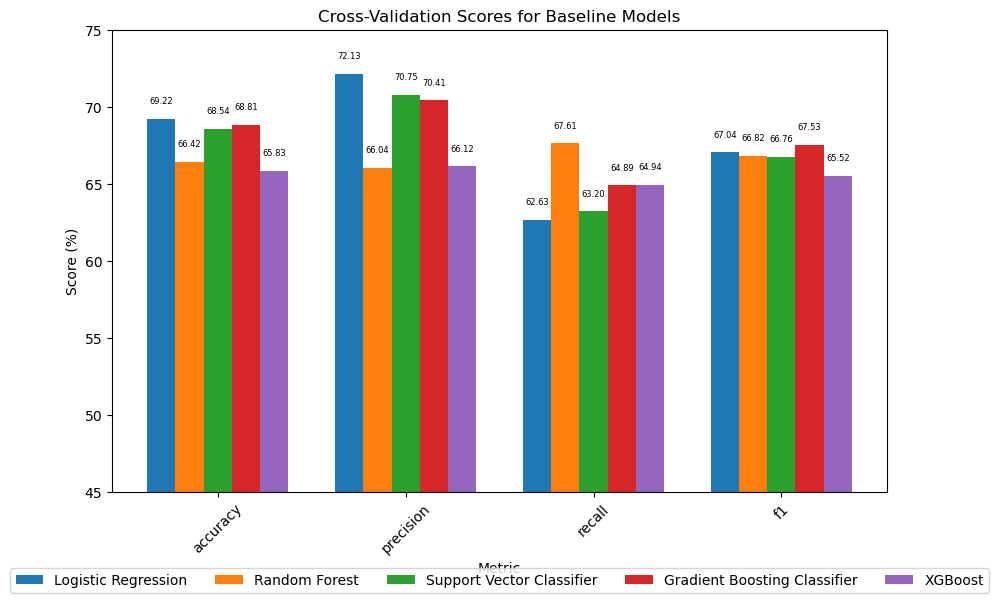

In [31]:
# Create a list of metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Create a list of model names
models = merged_df['Classifier'].tolist()

# Extract the cross-validation scores for each metric
cv_scores = merged_df[['cv_accuracy', 'cv_precision', 'cv_recall', 'cv_f1']].values

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Set the bar width and positions
bar_width = 0.15
r = np.arange(len(metrics))

# Loop through each model and create a bar for each metric
for i, model in enumerate(models):
    ax.bar(r + i * bar_width, cv_scores[i] * 100, bar_width, label=model)
    for j, score in enumerate(cv_scores[i]):
        ax.text(r[j] + i * bar_width, score * 100 + 1, '{:.2f}'.format(score * 100), ha='center', fontsize=6)

# Set the x-axis tick labels
ax.set_xticks(r + bar_width * 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Score (%)')

# Set the x-axis label
ax.set_xlabel('Metric')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Set the y-axis limits
ax.set_ylim(45, 75)  # Adjust the limits as needed

# Add a title
ax.set_title('Cross-Validation Scores for Baseline Models')

# Add a legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)

# Display the plot
plt.show()

Summary of comparison of the 4 metrics for the 5 baseline models:
- Accuracy:
For accuracy, Logistic Regression performs the best with a score of around 69.19%, followed closely by Gradient Boosting Classifier at around 68.58%.

- Precision:
In terms of precision, Logistic Regression achieves the highest score of approximately 72.11%, while Random Forest and XGBoost have relatively lower scores of around 65.69% and 65.98%, respectively.

- Recall:
For recall, Random Forest has the highest score of around 66.86%, followed by Gradient Boosting Classifier at around 64.62%. Logistic Regression and Support Vector Classifier have slightly lower recall scores.

- F1 Score:
The F1 scores, which combine precision and recall, show Gradient Boosting Classifier performing the best with a score of around 67.28%, closely followed by Logistic Regression at around 66.98%.

Gradient Boosting Classifier appears to be the most consistent performer, achieving high scores in accuracy, precision and F1 scores, while also having a competitive recall score. It is followed closely by Logistic Regression which has the highest scores in accuracy and precision and competitive F1 scores. Support Vector Classifier performs well in accuracy and precision but has lower recall scores.

Train Scores for Baseline Models

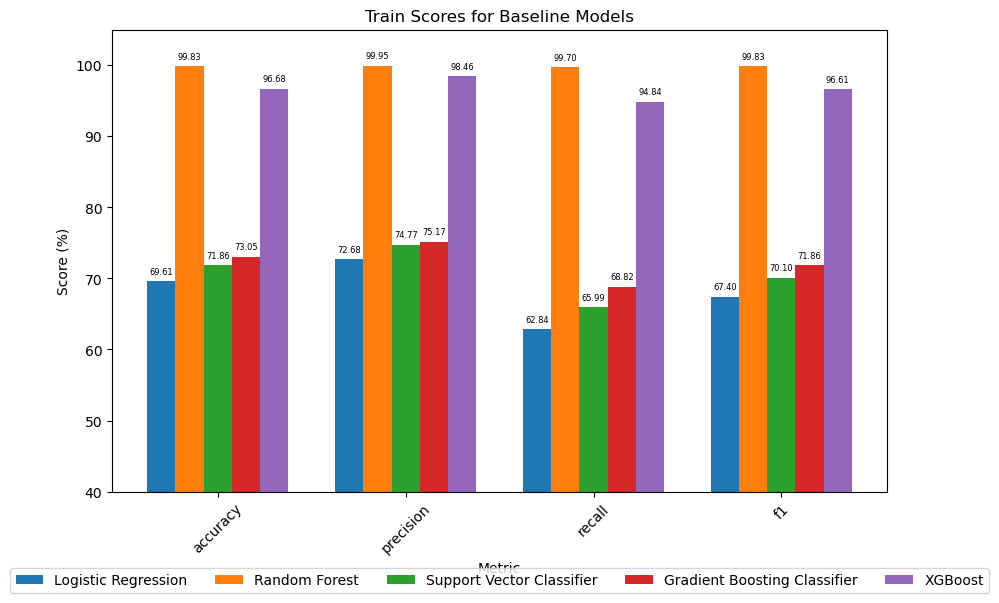

In [32]:
# Create a list of metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Create a list of model names
models = merged_df['Classifier'].tolist()

# Extract the cross-validation scores for each metric
cv_scores = merged_df[['train_accuracy', 'train_precision', 'train_recall', 'train_f1']].values

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Set the bar width and positions
bar_width = 0.15
r = np.arange(len(metrics))

# Loop through each model and create a bar for each metric
for i, model in enumerate(models):
    ax.bar(r + i * bar_width, cv_scores[i] * 100, bar_width, label=model)
    for j, score in enumerate(cv_scores[i]):
        ax.text(r[j] + i * bar_width, score * 100 + 1, '{:.2f}'.format(score * 100), ha='center', fontsize=6)

# Set the x-axis tick labels
ax.set_xticks(r + bar_width * 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Score (%)')

# Set the x-axis label
ax.set_xlabel('Metric')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Set the y-axis limits
ax.set_ylim(40, 105)  # Adjust the limits as needed

# Add a title
ax.set_title('Train Scores for Baseline Models')

# Add a legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)

# Display the plot
plt.show()

Summary of comparison of the 4 metrics for the 5 baseline models:
- Accuracy:
For accuracy, 2 models, namely Random Forest and XGBoost perform exceptionally well on the training data, with scores ranging from around 99.84% for Random Forest to around 96.28% for XGBoost. The other 3 models have lower accuracy ranging from 69.61% to 72.91%.

- Precision:
In terms of precision, it follows similar trend with accuracy. Random Forest and XGBoost perform exceptionally well on the training data, with scores ranging from 99.84% for Random Forest to 98.54% for XGBoost. The other 3 models have lower accuracy ranging from 72.68% to 75.14%.

- Recall:
For recall, Random Forest and XGBoost again perform the best, with scores around 99.84% and 93.95%, respectively. Logistic Regression and Support Vector Classifier have lower recall scores of around 62.84% and 65.99%, respectively.

- F1 Score:
The F1 scores, which combine precision and recall, show a similar pattern. Random Forest and XGBoost have the highest F1 scores of around 99.84% and 96.19%, respectively, while Logistic Regression and Support Vector Classifier have lower F1 scores of around 67.40% and 70.10%, respectively.

It is important to note that these scores are obtained on the training data, which means they may not accurately reflect the models' performance on unseen data due to potential overfitting. However, the high scores across most models and metrics suggest that the models are able to learn the patterns in the training data effectively.

Random Forest and XGBoost appear to be the top performers on the training data, achieving high scores across all metrics. Logistic Regression and Support Vector Classifier, while still lag behind the two leader in the 4 metrics.

Test Scores for Baseline Models

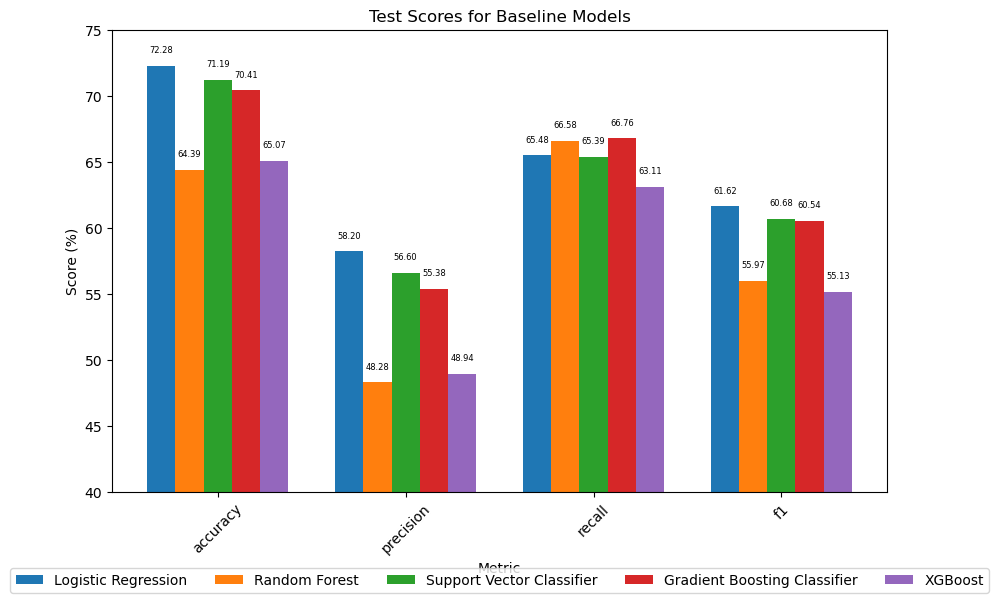

In [33]:
# Create a list of metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Create a list of model names
models = merged_df['Classifier'].tolist()

# Extract the cross-validation scores for each metric
cv_scores = merged_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1']].values

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Set the bar width and positions
bar_width = 0.15
r = np.arange(len(metrics))

# Loop through each model and create a bar for each metric
for i, model in enumerate(models):
    ax.bar(r + i * bar_width, cv_scores[i] * 100, bar_width, label=model)
    for j, score in enumerate(cv_scores[i]):
        ax.text(r[j] + i * bar_width, score * 100 + 1, '{:.2f}'.format(score * 100), ha='center', fontsize=6)

# Set the x-axis tick labels
ax.set_xticks(r + bar_width * 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Score (%)')

# Set the x-axis label
ax.set_xlabel('Metric')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Set the y-axis limits
ax.set_ylim(40, 75)  # Adjust the limits as needed

# Add a title
ax.set_title('Test Scores for Baseline Models')

# Add a legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)

# Display the plot
plt.show()

Summary of comparison of the 4 metrics for the 5 baseline models:
- Accuracy:
In terms of accuracy, Logistic Regression performs the best with a score of around 72.28%, followed by Support Vector Classifier at around 71.19%. Random Forest and XGBoost have lower accuracy scores at 65.41% and 65.54% respectively.

- Precision:
For precision, the scores are the lowest for all 4 models compared to other metrics. Logistic Regression achieves the highest score of around 58.20%, closely followed by Support Vector Classifier at around 56.60%. Random Forest and XGBoost have lower precision scores of around 49.37% and 49.48%, respectively.

- Recall:
In terms of recall, the scores do not differ greatly among the models. Random Forest performs the best with a score of around 67.76%, followed by Gradient Boosting Classifier at around 66.58%.

- F1 Score:
The F1 scores, which combine precision and recall is the next lower score after precision. Logistic Regression is the top performer with a score of around 61.62%, followed by Support Vector Classifier at around 60.68%. Random Forest and XGBoost have lower F1 scores of around 57.12% and 56.30%, respectively.

Overall, Logistic Regression and Support Vector Classifier appear to be the strongest performers on the test set, with Logistic Regression having slightly higher scores in accuracy, and F1, while Support Vector Classifier leads in recall.

It's important to note that the test scores are generally lower than the training scores, which is expected due to the potential overfitting of the models on the training data. The drop in performance from training to test sets highlights the importance of evaluating models on unseen data to assess their generalization capabilities.